In [1]:
from math import comb,ceil

***Credit scoring problem setup***

***Problem***/
Predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

Let's write the function that will replace NaN values with the median for each column.

In [5]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table   

Now, read the data:


In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/credit_scoring_sample.csv', sep=';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [7]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Check the class balance:

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

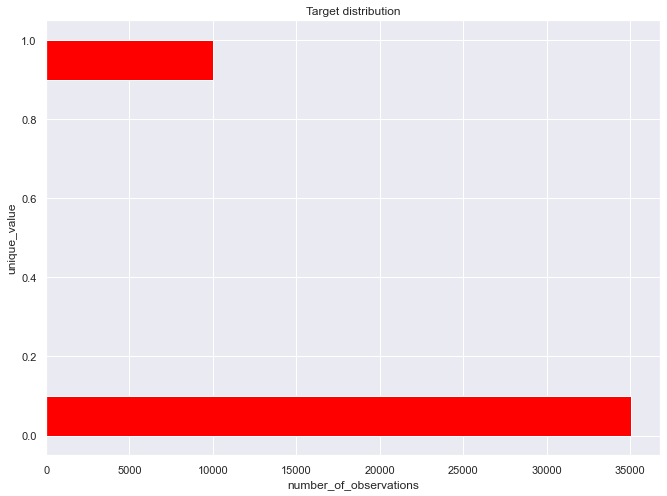

In [8]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Separate the input variable names by excluding the target:

In [74]:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Apply the function to replace NaN values:

In [10]:
table = fill_nan(data)

Seperate the taarget and the input features:

In [11]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']


***Boostrapping***

Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level.

In [12]:
import scipy
from scipy import stats
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# define 
age_delay=table[table.SeriousDlqin2yrs==1].age
age_delay.describe()

count    10026.000000
mean        45.926591
std         12.916289
min         21.000000
25%         36.000000
50%         45.000000
75%         54.000000
max        101.000000
Name: age, dtype: float64

In [13]:
# generate bootstrap samples
# i use mean to generate the bootstrap replicates
def bootstrap_rep(data,func, size):
    replicates=np.empty(size) # create empty array to store repl.
    
    for i in range(size): #create bootstrap replicates
        # creat bootstrap sample
        sample=np.random.choice(data, size=len(data)) #randomly choose data for a sample
        replicates[i]=func(sample) #get the statistic (here: mean)
    return replicates # all the mean values from samples


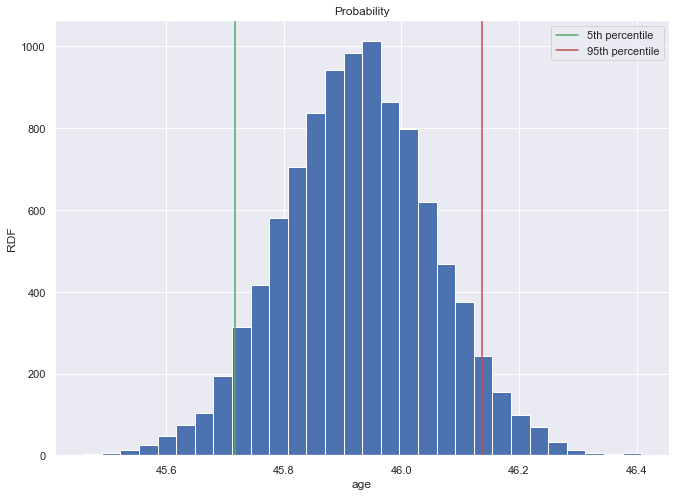

In [14]:
n_rep = 10000 # number of replicates in bootstrap
age_replicates = bootstrap_rep(age_delay, np.mean, n_rep)

# 90 confidence interval is: lowe limit = 2.5 and upper limit = 97.5

plt.hist(age_replicates, bins =30)
plt.axvline(x=np.percentile(age_replicates, [5]), ymin=0, ymax=1, label='5th percentile', c='g')
plt.axvline(x=np.percentile(age_replicates, [95]), ymin=0, ymax=1, label='95th percentile', c='r')
                                            
plt.xlabel('age')
plt.ylabel('RDF')
plt.title('Probability')
plt.legend()
plt.show()

In [15]:
confident_interval = np.percentile(age_replicates, [5, 95])
print('Confident interval of the average age of customer who delay repayment:[{:.2f}, {:.2f}]'.format(confident_interval[0],confident_interval[1]))

Confident interval of the average age of customer who delay repayment:[45.72, 46.14]


***Logistic Regression***

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics

Now, we will create a LogisticRegression model and use class_weight='balanced' to make up for our unbalanced classes.

In [17]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

Let's try to find the best regularization coefficient, which is the coefficient C for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [18]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In order to find the optimal value of C, let's apply stratified 5-fold validation and look at the ROC AUC against different values of the parameter C. Use the StratifiedKFold function for this:

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the Area Under the Curve (AUC). ROC AUC varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model.

***Question 3.*** Perform a Grid Search with the scoring metric "roc_auc" for the parameter C. Which value of the parameter C is optimal?

In [20]:
from sklearn.model_selection import GridSearchCV
lr.fit(X,y)
lr_grid = GridSearchCV(lr, parameters, scoring='roc_auc', cv = skf)
lr_grid.fit(X,y)
C = list(lr_grid.best_params_.values())
print("Parameter C with value C = {} is optimal".format(C))

Parameter C with value C = [0.001] is optimal


***Question 4:*** Can we consider the best model stable? The model is stable if the standard deviation on validation is less than 0.5%. Save the ROC AUC value of the best model; it will be useful for the following tasks.


In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import explained_variance_score 

In [22]:
# best standard deviation 
std=np.mean(lr_grid.cv_results_['std_test_score'])
print(std)
if std < 0.5/100:
    print("stable")
else :
    print("unstable")
    

0.0068617398832153615
unstable


In [23]:
# save ROCAUC
#rocauc_score = roc_auc_score(y_holdout, lr_grid.decision_function(X_holdout))
#rocauc_score = roc_auc_score(y, lr_grid.decision_function(X))

lreg = LogisticRegression(C= C[0],random_state=5, class_weight='balanced')
lreg.fit(X,y)
ra_score = roc_auc_score(y, lreg.predict(X))
print(ra_score)

#or
lr_ocauc_score = roc_auc_score(y, lr_grid.predict(X))
lr_ocauc_score

0.7150564965715392


0.7150564965715392

***Feature Importance***

***Question 5.*** Feature importance is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them. What is the most important feature for the best logistic regression model?


In [59]:
from sklearn.preprocessing import normalize, MinMaxScaler
X_normalized = normalize(X, norm='l2',  axis=1, copy=True, return_norm=False )

In [63]:
norm=MinMaxScaler().fit(X)
X_norm=norm.transform(X)

[[7.84481866e-03 0.00000000e+00 3.06325460e-05 ... 0.00000000e+00
  9.99969228e-01 0.00000000e+00]
 [8.98519701e-03 0.00000000e+00 5.99529525e-01 ... 0.00000000e+00
  8.00302203e-01 0.00000000e+00]
 [6.15049871e-03 0.00000000e+00 6.84245982e-05 ... 0.00000000e+00
  9.99981083e-01 0.00000000e+00]
 ...
 [1.26656477e-02 0.00000000e+00 1.58600907e-04 ... 0.00000000e+00
  9.99919553e-01 6.66613035e-04]
 [4.01020628e-03 8.53235378e-05 4.13988099e-05 ... 0.00000000e+00
  9.99991864e-01 4.26617689e-04]
 [4.93415021e-03 2.19295565e-04 8.80451956e-05 ... 0.00000000e+00
  9.99987775e-01 2.19295565e-04]]


In [68]:
# fit scaler on the training data
lreg.fit(X_norm,y) # with normalize with minmax


importance = list(abs(lreg.coef_[0]))

#summarize feature importance
for i, v in enumerate(importance):
    print("{}".format(X.columns[i]))
    print("importance absolut score: {:.5f}".format(v))
    print()

age
importance absolut score: 0.66912

NumberOfTime30-59DaysPastDueNotWorse
importance absolut score: 0.19081

DebtRatio
importance absolut score: 0.00211

NumberOfTimes90DaysLate
importance absolut score: 0.17314

NumberOfTime60-89DaysPastDueNotWorse
importance absolut score: 0.14457

MonthlyIncome
importance absolut score: 0.00489

NumberOfDependents
importance absolut score: 0.18175



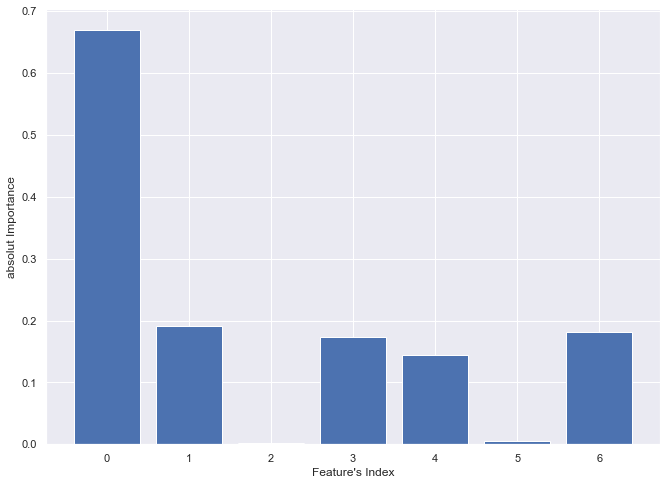

'age'

In [65]:
from matplotlib import pyplot as plt
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel("Feature's Index")
plt.ylabel("absolut Importance")
plt.show()

most_imp = max(importance)
Imp_Feature=X.columns[importance.index(most_imp)]
Imp_Feature


***Question 6.*** Calculate how much DebtRatio affects our prediction using the softmax function. What is its value?

In [66]:
X.describe()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
count,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,4.506300e+04,45063.000000
mean,51.210949,0.750993,352.062688,0.570712,0.505870,6.205560e+03,0.770055
std,14.651533,6.184521,2467.556358,6.173106,6.153609,1.137297e+04,1.123438
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,40.000000,0.000000,0.176373,0.000000,0.000000,3.721000e+03,0.000000
50%,51.000000,0.000000,0.373949,0.000000,0.000000,5.166000e+03,0.000000
75%,62.000000,0.000000,0.857027,0.000000,0.000000,7.121500e+03,1.000000
max,107.000000,98.000000,326442.000000,98.000000,98.000000,1.794060e+06,10.000000


In [67]:
from scipy.special import softmax
Index=list(X.columns).index("DebtRatio")
softmax(importance)[Index]

0.11500489633545213

***Question 7.*** Let's see how we can interpret the impact of our features. For this, recalculate the logistic regression with absolute values, that is without scaling. Next, modify the customer's age by adding 20 years, keeping the other features unchanged. How many times will the chance that the customer will not repay their debt increase? You can find an example of the theoretical calculation here.

In [76]:
lreg2= LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
lreg2.fit(X,y)
imp_df=pd.DataFrame({
    'feature':independent_columns_names,
    'importance':lreg2.coef_.flatten()
}).sort_values(by="importance", ascending=False)
imp_df.head(7)

# plt.bar([x for x in range(len(imp_with_neg))], imp_with_neg)
# plt.xlabel("Feature's Index")
# plt.ylabel("absolut Importance")
# plt.show()
# id=list(X.columns).index("age")
# print("age's index: ",id)
# imp_with_neg = list(lreg.coef_[0])
# print("Importance of age without scaling=",softmax(imp_with_neg)[id])


,feature,importance
1,NumberOfTime30-59DaysPastDueNotWorse,0.446832
3,NumberOfTimes90DaysLate,0.390380
4,NumberOfTime60-89DaysPastDueNotWorse,0.216038
6,NumberOfDependents,0.191726
2,DebtRatio,-0.000006
5,MonthlyIncome,-0.000011
0,age,-0.013656


In [85]:
ind = imp_df[imp_df['feature']=='age'].index
ind[0]

0

In [86]:
softmax(lreg2.coef_.flatten())[ind[0]]

0.11632788673401903

In [91]:
#imp_df[imp_df["feature"]=="age"]['importance']
np.exp(imp_df[imp_df["feature"]=="age"]['importance']*20)

0    0.761009
Name: importance, dtype: float64